In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [12]:
# Load the CSV file
df = pd.read_csv('layer2_data.csv')

# Clean data: convert label to numeric and filter valid labels (0-5)
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)
df = df[df['label'].isin([0, 1, 2, 3, 4, 5])].copy()

print(f"Loaded {len(df)} samples")
print(f"Label distribution:\n{df['label'].value_counts().sort_index()}")
df.head(10)

Loaded 5818 samples
Label distribution:
label
0    1362
1    1206
2     908
3     882
4     671
5     789
Name: count, dtype: int64


,text,label
0,WACC represents the blended cost of a company’...,0
1,A DCF estimates intrinsic value by discounting...,0
2,EBITDA measures operating performance before i...,0
3,Net working capital equals current assets minu...,0
4,Free cash flow is cash generated after capital...,0
5,Cost of equity is often estimated using the CA...,0
6,Enterprise value reflects the total value of a...,0
7,Beta measures a stock’s sensitivity to market ...,0
8,Financial leverage increases potential returns...,0
9,Depreciation allocates asset cost over its use...,0


In [13]:
# Label mappings for Layer 2 multi-class classification
id2label = {
    0: "answer_submission",
    1: "clarification_request",
    2: "process_inquiry",
    3: "challenge_assessment",
    4: "off_topic",
    5: "small_talk"
}
label2id = {v: k for k, v in id2label.items()}

NUM_LABELS = len(id2label)
print(f"Number of classes: {NUM_LABELS}")
print(f"Labels: {list(id2label.values())}")

Number of classes: 6
Labels: ['answer_submission', 'clarification_request', 'process_inquiry', 'challenge_assessment', 'off_topic', 'small_talk']


In [14]:
# First split: 70% train, 30% temp (for val+test)
train_df, temp_df = train_test_split(
    df, 
    test_size=0.30, 
    random_state=RANDOM_SEED, 
    stratify=df['label']
)

# Second split: 15% val, 15% test (50-50 split of the 30%)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.50, 
    random_state=RANDOM_SEED, 
    stratify=temp_df['label']
)

print(f"Train size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train size: 4072 (70.0%)
Val size: 873 (15.0%)
Test size: 873 (15.0%)


In [15]:
# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df[['text', 'label']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['text', 'label']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['text', 'label']].reset_index(drop=True))

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4072
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 873
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 873
    })
})

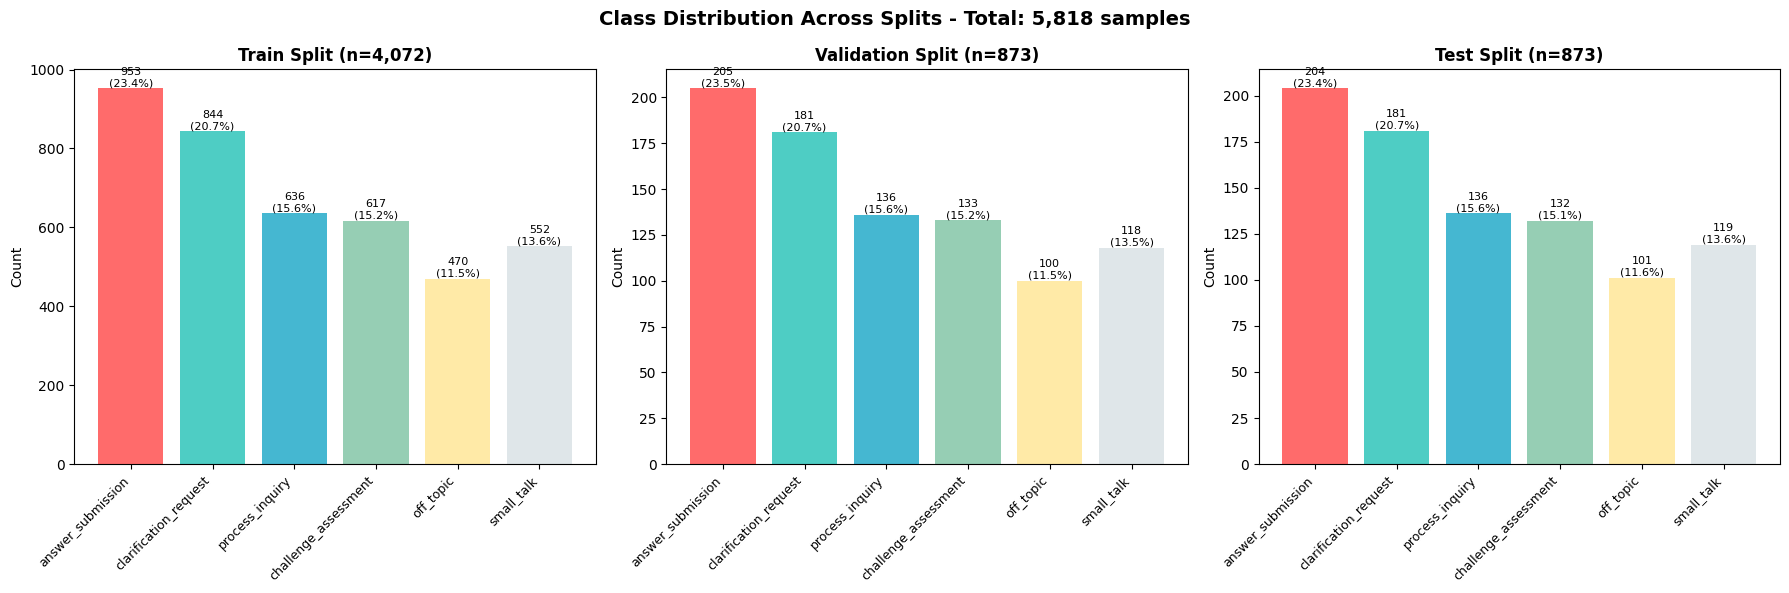

In [16]:
# Visualize class distribution across splits
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

splits = [
    ('Train', train_df),
    ('Validation', val_df),
    ('Test', test_df)
]

colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#ffeaa7', '#dfe6e9']
class_names = [id2label[i] for i in range(NUM_LABELS)]

for idx, (split_name, split_df) in enumerate(splits):
    counts = split_df['label'].value_counts().sort_index()
    percentages = (counts / len(split_df) * 100)
    
    bars = axes[idx].bar(range(NUM_LABELS), counts.values, color=colors)
    axes[idx].set_title(f'{split_name} Split (n={len(split_df):,})', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticks(range(NUM_LABELS))
    axes[idx].set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
    
    # Add count labels on bars
    for bar, count, pct in zip(bars, counts.values, percentages.values):
        label = f'{count:,}\n({pct:.1f}%)'
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                       label, ha='center', va='bottom', fontsize=8)

plt.suptitle(f'Class Distribution Across Splits - Total: {len(df):,} samples', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "answerdotai/ModernBERT-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id
)

model.config

Loading weights: 100%|██████████| 136/136 [00:00<00:00, 1641.58it/s, Materializing param=model.layers.21.mlp_norm.weight]    
ModernBertForSequenceClassification LOAD REPORT from: answerdotai/ModernBERT-base
Key               | Status     | 
------------------+------------+-
decoder.bias      | UNEXPECTED | 
classifier.weight | MISSING    | 
classifier.bias   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


ModernBertConfig {
  "architectures": [
    "ModernBertForMaskedLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 50281,
  "classifier_activation": "gelu",
  "classifier_bias": false,
  "classifier_dropout": 0.0,
  "classifier_pooling": "mean",
  "cls_token_id": 50281,
  "decoder_bias": true,
  "deterministic_flash_attn": false,
  "dtype": "float32",
  "embedding_dropout": 0.0,
  "eos_token_id": 50282,
  "global_attn_every_n_layers": 3,
  "gradient_checkpointing": false,
  "hidden_activation": "gelu",
  "hidden_size": 768,
  "id2label": {
    "0": "answer_submission",
    "1": "clarification_request",
    "2": "process_inquiry",
    "3": "challenge_assessment",
    "4": "off_topic",
    "5": "small_talk"
  },
  "initializer_cutoff_factor": 2.0,
  "initializer_range": 0.02,
  "intermediate_size": 1152,
  "label2id": {
    "answer_submission": 0,
    "challenge_assessment": 3,
    "clarification_request": 1,
    "off_topic": 4,
    "process_inquiry": 2,
  

In [18]:
# Freeze all base model parameters (train only classification head)
for param in model.model.parameters():
    param.requires_grad = False

# Verify: count trainable vs frozen parameters
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f"Trainable: {trainable:,} | Frozen: {frozen:,}")

Trainable: 595,206 | Frozen: 149,014,272


In [19]:
from transformers import DataCollatorWithPadding

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

tokenized_dataset = dataset_dict.map(tokenize_fn, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_dataset

Map: 100%|██████████| 873/873 [00:00<00:00, 70407.79 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4072
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 873
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 873
    })
})

In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from scipy.special import softmax

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    probs = softmax(logits, axis=-1)
    confidence = np.max(probs, axis=-1)
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, preds, average=None, labels=list(range(NUM_LABELS))
    )
    
    # Macro averages
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro'
    )
    
    # Per-class AUC (one-vs-rest)
    per_class_auc = []
    for i in range(NUM_LABELS):
        binary_labels = (labels == i).astype(int)
        if binary_labels.sum() > 0 and binary_labels.sum() < len(binary_labels):
            auc = roc_auc_score(binary_labels, probs[:, i])
        else:
            auc = 0.0
        per_class_auc.append(auc)
    
    # Confidence stats
    correct_mask = preds == labels
    
    metrics = {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": macro_f1,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_auc": np.mean(per_class_auc),
        "confidence_mean": confidence.mean(),
        "confidence_correct": confidence[correct_mask].mean() if correct_mask.any() else 0.0,
        "confidence_wrong": confidence[~correct_mask].mean() if (~correct_mask).any() else 0.0,
    }
    
    # Add per-class metrics
    for i, label_name in id2label.items():
        metrics[f"f1_{label_name}"] = f1[i]
        metrics[f"precision_{label_name}"] = precision[i]
        metrics[f"recall_{label_name}"] = recall[i]
        metrics[f"auc_{label_name}"] = per_class_auc[i]
    
    return metrics

In [21]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./layer2_model",
    learning_rate=2e-4,
    num_train_epochs=10,  
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=64,  
    weight_decay=0.05,
    warmup_steps=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=50,  
    report_to=[],
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
trainer.train()

In [22]:
# Load the best model from training
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

model = AutoModelForSequenceClassification.from_pretrained("./layer2_model/checkpoint-1280")
tokenizer = AutoTokenizer.from_pretrained("./layer2_model/checkpoint-1280")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"✓ Model loaded from ./layer2_model/checkpoint-1280")

Loading weights: 100%|██████████| 138/138 [00:00<00:00, 1709.72it/s, Materializing param=model.layers.21.mlp_norm.weight]    


✓ Model loaded from ./layer2_model/checkpoint-1280


In [23]:
# Evaluate the loaded model on test set
from transformers import Trainer, TrainingArguments

eval_trainer = Trainer(
    model=model,
    args=TrainingArguments(output_dir="./eval_tmp", per_device_eval_batch_size=64),
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

test_results = eval_trainer.evaluate(tokenized_dataset["test"])
test_results

/Users/isaacanwar/Desktop/Projects/Classification-RAG-gaurdrail/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


{'eval_loss': 0.058414436876773834,
 'eval_model_preparation_time': 0.0009,
 'eval_accuracy': 0.9782359679266895,
 'eval_macro_f1': 0.9792315032436782,
 'eval_macro_precision': 0.979689933152974,
 'eval_macro_recall': 0.9788572396865481,
 'eval_macro_auc': 0.9995889899023821,
 'eval_confidence_mean': 0.971259355545044,
 'eval_confidence_correct': 0.9782177209854126,
 'eval_confidence_wrong': 0.6585021018981934,
 'eval_f1_answer_submission': 0.9828009828009828,
 'eval_precision_answer_submission': 0.9852216748768473,
 'eval_recall_answer_submission': 0.9803921568627451,
 'eval_auc_answer_submission': 0.9996775989917641,
 'eval_f1_clarification_request': 0.9725274725274725,
 'eval_precision_clarification_request': 0.9672131147540983,
 'eval_recall_clarification_request': 0.9779005524861878,
 'eval_auc_clarification_request': 0.9994810462108389,
 'eval_f1_process_inquiry': 0.9629629629629629,
 'eval_precision_process_inquiry': 0.9701492537313433,
 'eval_recall_process_inquiry': 0.95588235

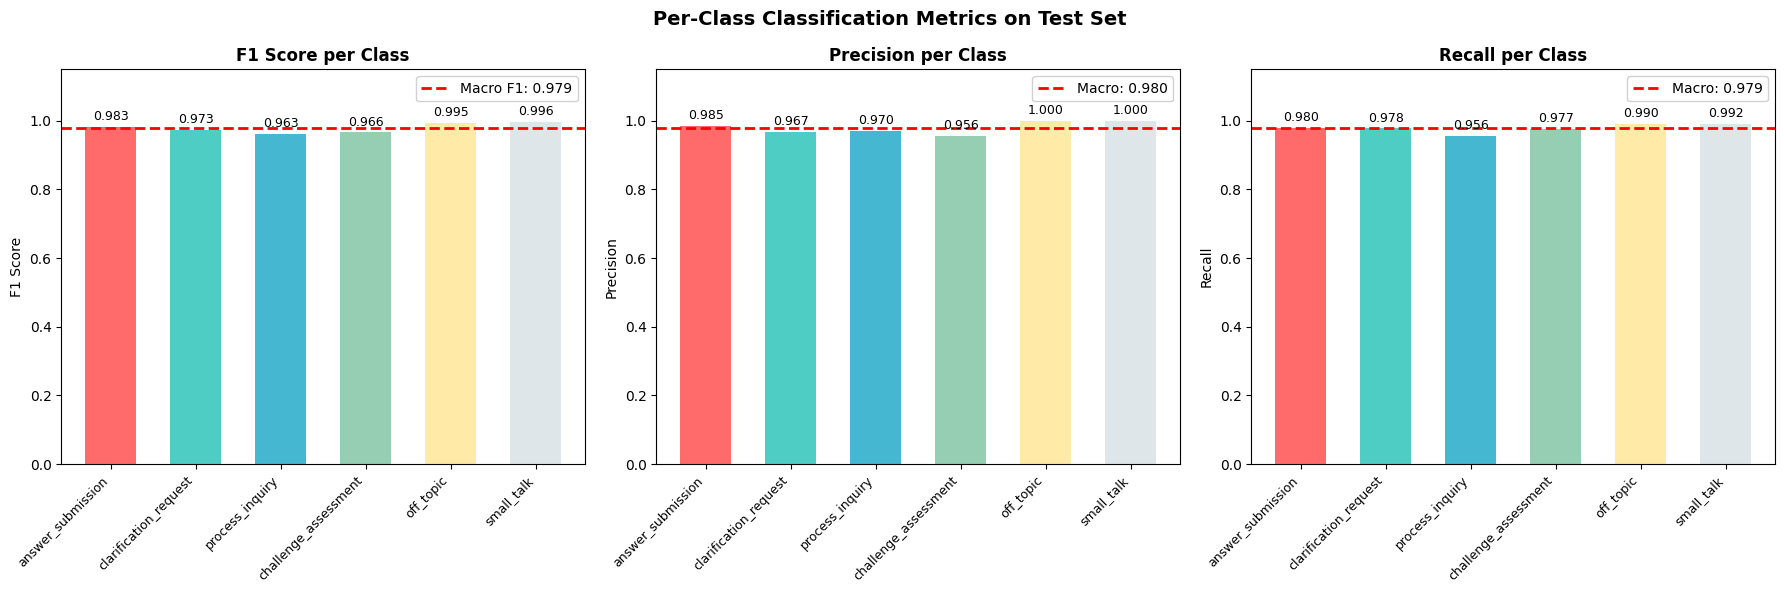

In [24]:
# Per-class F1, Precision, Recall bar chart
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

class_names = [id2label[i] for i in range(NUM_LABELS)]
x = np.arange(NUM_LABELS)
bar_width = 0.6

# F1 Scores
f1_scores = [test_results[f"eval_f1_{id2label[i]}"] for i in range(NUM_LABELS)]
bars = axes[0].bar(x, f1_scores, bar_width, color=colors)
axes[0].set_title('F1 Score per Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('F1 Score')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
axes[0].set_ylim(0, 1.15)
axes[0].axhline(y=test_results["eval_macro_f1"], color='red', linestyle='--', linewidth=2, label=f'Macro F1: {test_results["eval_macro_f1"]:.3f}')
axes[0].legend(loc='upper right', framealpha=0.9)
for bar, score in zip(bars, f1_scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{score:.3f}', ha='center', fontsize=9)

# Precision Scores
precision_scores = [test_results[f"eval_precision_{id2label[i]}"] for i in range(NUM_LABELS)]
bars = axes[1].bar(x, precision_scores, bar_width, color=colors)
axes[1].set_title('Precision per Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
axes[1].set_ylim(0, 1.15)
axes[1].axhline(y=test_results["eval_macro_precision"], color='red', linestyle='--', linewidth=2, label=f'Macro: {test_results["eval_macro_precision"]:.3f}')
axes[1].legend(loc='upper right', framealpha=0.9)
for bar, score in zip(bars, precision_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{score:.3f}', ha='center', fontsize=9)

# Recall Scores
recall_scores = [test_results[f"eval_recall_{id2label[i]}"] for i in range(NUM_LABELS)]
bars = axes[2].bar(x, recall_scores, bar_width, color=colors)
axes[2].set_title('Recall per Class', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Recall')
axes[2].set_xticks(x)
axes[2].set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
axes[2].set_ylim(0, 1.15)
axes[2].axhline(y=test_results["eval_macro_recall"], color='red', linestyle='--', linewidth=2, label=f'Macro: {test_results["eval_macro_recall"]:.3f}')
axes[2].legend(loc='upper right', framealpha=0.9)
for bar, score in zip(bars, recall_scores):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{score:.3f}', ha='center', fontsize=9)

plt.suptitle('Per-Class Classification Metrics on Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Interactive inference with confidence flagging
import torch

CONFIDENCE_THRESHOLD = 0.5  # Adjust based on threshold analysis above

query = ""  # <-- Enter your query here

inputs = tokenizer(query, return_tensors="pt", truncation=True, max_length=128)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)[0]

pred_class = probs.argmax().item()
confidence = probs[pred_class].item()
pred_label = id2label[pred_class]

if confidence >= CONFIDENCE_THRESHOLD:
    status = f"ACCEPTED - {pred_label}"
else:
    status = f"FLAGGED (low confidence) - Predicted: {pred_label}"

print(f"Query: {query}")
print(f"\nResult: {status}")
print(f"Confidence: {confidence:.1%}")
print("\n")
for i, label_name in id2label.items():
    marker = " <--" if i == pred_class else ""
    print(f"  {label_name}: {probs[i].item():.1%}{marker}")

Query: is this fine?

Result: ACCEPTED - process_inquiry
Confidence: 69.4%


  answer_submission: 0.1%
  clarification_request: 0.3%
  process_inquiry: 69.4% <--
  challenge_assessment: 9.0%
  off_topic: 0.0%
  small_talk: 21.2%
